In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

In [2]:
#Path management 

def list_directory_tree_with_os_walk(starting_directory):
    for root, directories, files in os.walk(starting_directory):
        print(f"Directory: {root}")
        for file in files:
            print(f"  File: {file}")

# Check the directory
starting_directory_noe = 'C:/Users/Noe/source/repos/Energy-forecasting-NTNU/data/'
starting_directory_hugo = 'C:/Users/hugob/OneDrive/Documents/ENSE3/3A/lectures/Machine Learning/Project/git/Energy-forecasting-NTNU/data'
os.chdir(starting_directory_hugo)
list_directory_tree_with_os_walk('.')

Directory: .
  File: .DS_Store
  File: my_first_submission_utf8.csv
  File: my_second_submission.csv
  File: Readme.md
  File: read_files.ipynb
  File: sample_submission.csv
  File: submission1.csv
  File: test.csv
Directory: .\.ipynb_checkpoints
  File: Data_exploration-checkpoint.ipynb
  File: Readme-checkpoint.md
  File: read_files-checkpoint.ipynb
Directory: .\A
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\B
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\C
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\catboost_info
  File: catboost_training.json
  File: learn_error.tsv
  File: test_error.tsv
  File: time_left.tsv
Directory: .\catboost_info\learn
  File: events.out.tfevents
Directory: .\catboost_i

In [3]:
#Load datasets #
#Targets
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

# Train estimated data
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

# Train observed data
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

#Test estimated data
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

#List of dataset
Train_datasets = [X_train_observed_a, X_train_observed_b, X_train_observed_c, 
            X_train_estimated_a, X_train_estimated_b,X_train_estimated_c
            ]
Train_datasets_names = [ "X_train_observed_a", "X_train_observed_b", "X_train_observed_c",
                        "X_train_estimated_a", "X_train_estimated_b", "X_train_estimated_c"
                        ]

Test_datasets = [X_test_estimated_a, X_test_estimated_b, X_test_estimated_c]

Target_datasets = [train_a, train_b, train_c]

### Quick data management for missing values

In [4]:
# Remove snow_density variable because too many Nan ==> Useless
for i, dataset in enumerate(Train_datasets):
    dataset = dataset.drop(columns = 'snow_density:kgm3')
    Train_datasets[i] = dataset

In [5]:
# Function to fill gaps in dataset
def fill_nan(Dataframe, feature):
    it_na = np.where(Dataframe[feature].isna())[0]
    
    #If missing value
    if len(it_na != 0):
        method = 'ffill' # ffill: Propagate last valid observation forward to next valid
        new_column = Dataframe[feature].fillna(method='ffill')
        
        if((np.any(new_column.isna()) == True)): 
            method = 'bfill' # bfill :Fill values by using the next valid observation to fill the gap.
            new_column = Dataframe[feature].fillna(method='bfill')
    
        if (np.any(new_column.isna()) == False):
            print("==> ", feature, " filled with ",method," method")
            Dataframe[feature] = new_column
        else:
            print("Still Nan values !!!")

In [6]:
# Fill for each train dataset for each variable where there is some Nan
for i, dataset in enumerate(Train_datasets):
    print("Dataset : ",  Train_datasets_names[i])
    nan_features = [var for var in dataset.columns if dataset[var].isnull().sum() > 0]
    for features in nan_features:
        fill_nan(dataset, features)
    print("\n")

Dataset :  X_train_observed_a
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method


Dataset :  X_train_observed_b
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method


Dataset :  X_train_observed_c
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method


Dataset :  X_train_estimated_a
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method


Dataset :  X_train_estimated_b
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method


Dataset :  X_train_estimated_c
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method




### Feature engineering

In [7]:
# Check for correlation
set_nbr = 0
corr_matrix = Train_datasets[set_nbr].corr()
print(Train_datasets_names[set_nbr])
corr_matrix.style.background_gradient(cmap='coolwarm')

X_train_observed_a


c:\Users\hugob\anaconda3\lib\site-packages\pandas\io\formats\style.py:3555: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Users\hugob\anaconda3\lib\site-packages\pandas\io\formats\style.py:3556: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
absolute_humidity_2m:gm3,1.000000,-0.804124,0.110840,0.352801,0.349927,0.024787,0.123430,0.974863,0.284847,0.291109,0.239287,0.243773,0.021256,nan,-0.119009,-0.069179,-0.148714,-0.085105,-0.098863,0.304652,-0.322754,0.147830,0.067724,-0.025242,0.165345,0.154403,-0.055802,0.261640,0.160016,0.143458,-0.203685,nan,-0.013563,0.034042,0.022875,0.432344,0.110364,0.900297,0.043038,-0.158686,-0.157917,0.050106,-0.258794,0.004869
air_density_2m:kgm3,-0.804124,1.000000,-0.159707,-0.473967,-0.463355,-0.105238,-0.060455,-0.838733,-0.402079,-0.415496,-0.393769,-0.409485,-0.067100,nan,0.063038,0.044146,0.075154,0.052815,0.058816,-0.386344,0.402335,0.280098,-0.084777,-0.012127,0.263756,0.275654,0.072122,-0.162900,0.141432,0.287484,0.316890,nan,0.013984,-0.065673,-0.067960,-0.504503,-0.063599,-0.915070,-0.103049,-0.011076,-0.017527,0.026196,0.142869,-0.000575
ceiling_height_agl:m,0.110840,-0.159707,1.000000,0.071831,0.066778,0.664970,0.037937,0.101108,0.055368,0.058749,0.236082,0.243613,-0.377015,nan,-0.018965,-0.010354,-0.026045,-0.014081,-0.016165,0.052470,-0.056461,0.097773,-0.012913,-0.063670,0.102267,0.099780,0.025814,-0.150385,-0.388320,0.097302,-0.061680,nan,-0.028779,-0.179834,0.040713,0.078340,-0.322444,0.255581,-0.187227,0.423864,-0.172588,-0.305707,-0.010682,-0.003096
clear_sky_energy_1h:J,0.352801,-0.473967,0.071831,1.000000,0.992332,0.053497,-0.080023,0.362016,0.911178,0.922412,0.719660,0.732282,0.002814,nan,-0.056605,-0.037862,-0.072751,-0.046583,-0.052732,0.650795,-0.690138,0.157747,-0.008042,-0.032567,0.160357,0.154124,-0.050700,0.054178,-0.339914,0.147883,-0.074640,nan,-0.020592,-0.039219,0.056788,0.847872,0.016904,0.438994,0.009891,0.092573,0.013025,0.069513,-0.343041,-0.005087
clear_sky_rad:W,0.349927,-0.463355,0.066778,0.992332,1.000000,0.050362,-0.079422,0.359138,0.917222,0.914733,0.727173,0.728482,0.003273,nan,-0.055061,-0.037588,-0.072560,-0.045965,-0.051830,0.651263,-0.693266,0.158353,-0.009060,-0.032314,0.160647,0.154566,-0.050494,0.052233,-0.313417,0.148472,-0.074147,nan,-0.020584,-0.041589,0.002422,0.851637,0.017788,0.424912,0.009648,0.083516,0.003153,0.063870,-0.327927,-0.006878
cloud_base_agl:m,0.024787,-0.105238,0.664970,0.053497,0.050362,1.000000,0.029038,0.018957,0.016105,0.019863,0.246256,0.252961,-0.394619,nan,-0.013806,-0.008638,-0.016642,-0.012054,-0.014636,0.027712,-0.029643,0.089278,-0.032314,-0.079654,0.092751,0.091005,0.031311,-0.117894,-0.467114,0.089255,-0.064314,nan,-0.019182,-0.134643,0.036471,0.048875,-0.274170,0.204864,-0.215561,0.449480,-0.208237,-0.377859,0.028942,0.001733
dew_or_rime:idx,0.123430,-0.060455,0.037937,-0.080023,-0.079422,0.029038,1.000000,0.123717,-0.080196,-0.081953,-0.055274,-0.056277,-0.050331,nan,-0.010698,-0.009383,-0.013659,-0.009211,-0.010723,-0.105438,0.102463,0.005786,-0.009744,-0.016899,0.009538,0.008596,-0.177816,-0.007136,0.100292,0.007660,-0.015160,nan,-0.003851,-0.022419,-0.039829,-0.072291,-0.036164,0.109030,-0.033482,-0.031053,-0.108146,-0.038802,0.005134,-0.001638
dew_point_2m:K,0.974863,-0.838733,0.101108,0.362016,0.359138,0.018957,0.123717,1.000000,0.296786,0.303062,0.245491,0.250216,0.059003,nan,-0.126655,-0.076161,-0.156335,-0.092939,-0.106866,0.310899,-0.329485,0.137601,0.065673,-0.025590,0.155653

In [8]:
#Find high correlated variables in train datasets
List_correlated_variable = []

for set_nbr in range(len(Train_datasets)):
    corr_matrix = Train_datasets[set_nbr].corr()
    threshold = 0.95

    idx = np.where((np.abs(corr_matrix) > threshold) & (corr_matrix !=1))
    print(round(idx[0].shape[0]/2)," strong correlation ==> \n")
    columns_corr = []
    ind_double = []

    # To select the correct variable (without time and time forecast in the pandaframe)
    if set_nbr > 2:
        add_int = 2
    else:
        add_int = 1

    for i in range(idx[0].shape[0]):
        if ( ind_double.count((idx[0][i],idx[1][i])) == 0):
            ind_double.append((idx[1][i],idx[0][i]))
            
            print( 
                    "Correlation between : ", 
                    Train_datasets[set_nbr].columns[idx[0][i]+add_int], "and", 
                    Train_datasets[set_nbr].columns[idx[1][i]+add_int], " = ",
                    corr_matrix.iloc[idx[0][i], idx[1][i]], "\n"
                )
            
            columns_corr.append((Train_datasets[set_nbr].columns[idx[0][i]+add_int],
                                Train_datasets[set_nbr].columns[idx[1][i]+add_int]
                                ))
            List_correlated_variable.append(columns_corr)

10  strong correlation ==> 

Correlation between :  absolute_humidity_2m:gm3 and dew_point_2m:K  =  0.9748628282981654 

Correlation between :  clear_sky_energy_1h:J and clear_sky_rad:W  =  0.9923317834232241 

Correlation between :  diffuse_rad:W and diffuse_rad_1h:J  =  0.9869871153005173 

Correlation between :  direct_rad:W and direct_rad_1h:J  =  0.9852611696388884 

Correlation between :  msl_pressure:hPa and pressure_100m:hPa  =  0.9997717603345274 

Correlation between :  msl_pressure:hPa and pressure_50m:hPa  =  0.999914482392545 

Correlation between :  msl_pressure:hPa and sfc_pressure:hPa  =  0.9999042081912317 

Correlation between :  pressure_100m:hPa and pressure_50m:hPa  =  0.9999178389342016 

Correlation between :  pressure_100m:hPa and sfc_pressure:hPa  =  0.9996884691072808 

Correlation between :  pressure_50m:hPa and sfc_pressure:hPa  =  0.9999182187872183 

10  strong correlation ==> 

Correlation between :  absolute_humidity_2m:gm3 and dew_point_2m:K  =  0.97361

We can see same correlation appears for all the datasets
==> Thus we can remove one of the varaible each time except for pressure variables which seem to be all correlated together

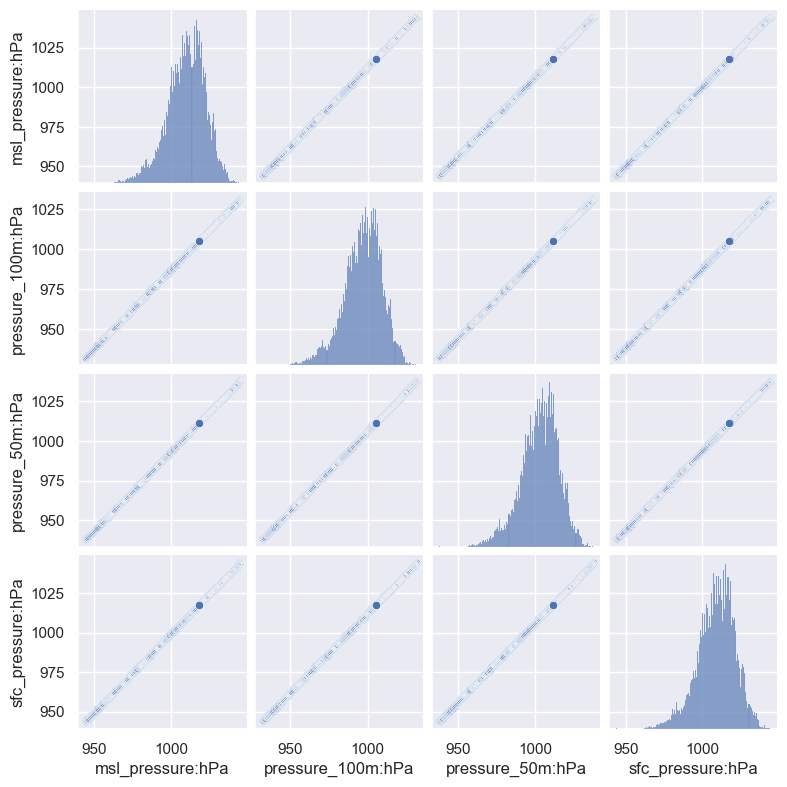

In [9]:
sns.set()
cols_pressure = ['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa']
sns.pairplot(Train_datasets[0][cols_pressure], height = 2)
plt.show()

In [10]:
high_correlated_var_to_del = [
    "dew_point_2m:K",
    "clear_sky_energy_1h:J",
    "diffuse_rad_1h:J",
    "direct_rad_1h:J",
    "msl_pressure:hPa",
    "pressure_50m:hPa",
    "sfc_pressure:hPa"
]
for i, dataset in enumerate(Train_datasets):
    dataset = dataset.drop(columns = high_correlated_var_to_del)
    Train_datasets[i] = dataset

Goal : Get data into proper form to use it for training a maching learning algorithm
Issues : 
    1. Not same date between the three location
    2. Gap in target data
    3. Forecast data has one more feature than observed data (Forecast time)
    4. Not the same time step in observed and forcast data
  
  Ideas to solve them (simpliest ones):
    1. Reduce dataset to the most restrictive dataset
    2. Get the data from the same date previous or next year
    3. Don't take into account forecast time feature
    4. Make an average over 4hours of each feature

Try to solve problem 2

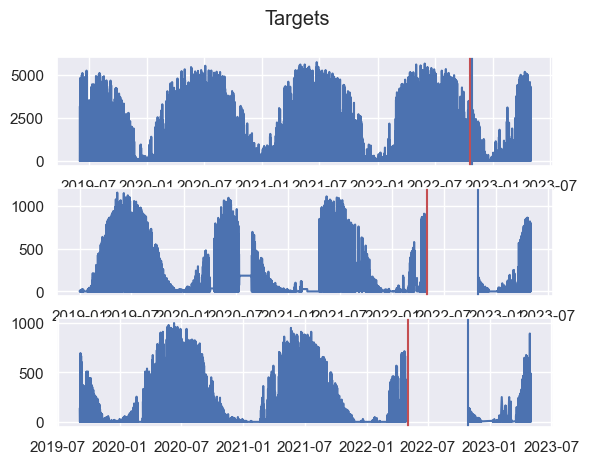

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('Targets')
ax1.plot(train_a.iloc[:,0], train_a.iloc[:,1])
ax1.axvline(Train_datasets[0].iloc[-1,0],0,5000, c='r')
ax1.axvline(Train_datasets[3].iloc[0,0],0,5000, c='b')

ax2.plot(train_b.iloc[:,0], train_b.iloc[:,1])
ax2.axvline(Train_datasets[1].iloc[-1,0],0,5000, c='r')
ax2.axvline(Train_datasets[4].iloc[0,0],0,5000, c='b')

ax3.plot(train_c.iloc[:,0], train_c.iloc[:,1])
ax3.axvline(Train_datasets[2].iloc[-1,0],0,5000, c='r')
ax3.axvline(Train_datasets[5].iloc[0,0],0,5000, c='b')

plt.show()

In [12]:
location = ["A", "B", "C"]
for i in range(3):
    print("Location ", location[i])
    print("Observed data : ", Train_datasets[i].iloc[0,0]," to ", Train_datasets[i].iloc[-1,0], " ,size = ",Train_datasets[i].shape )
    print("Forecast data : ", Train_datasets[i+3].iloc[0,0]," to ", Train_datasets[i+3].iloc[-1,0],  " ,size = ",Train_datasets[i+3].shape)
    print("Target : ", Target_datasets[i].iloc[0,0]," to ", Target_datasets[i].iloc[-1,0],  " ,size = ",Target_datasets[i].shape )
    print("Missing values in target =", np.any(Target_datasets[i].isna()))
    print("Zero values in target = ", np.any(Target_datasets[i] == 0) )
    print("\n")

Location  A
Observed data :  2019-06-02 22:00:00  to  2022-10-21 01:00:00  ,size =  (118669, 38)
Forecast data :  2022-10-27 07:00:18  to  2023-04-29 07:00:05  ,size =  (17576, 39)
Target :  2019-06-02 22:00:00  to  2023-04-30 23:00:00  ,size =  (34085, 2)
Missing values in target = False
Zero values in target =  True


Location  B
Observed data :  2019-01-01 00:00:00  to  2022-05-03 00:00:00  ,size =  (116929, 38)
Forecast data :  2022-10-27 07:00:18  to  2023-04-29 07:00:05  ,size =  (17576, 39)
Target :  2018-12-31 23:00:00  to  2023-04-30 23:00:00  ,size =  (32848, 2)
Missing values in target = True
Zero values in target =  True


Location  C
Observed data :  2019-01-01 00:00:00  to  2022-05-01 22:00:00  ,size =  (116825, 38)
Forecast data :  2022-10-27 07:00:18  to  2023-04-29 07:00:05  ,size =  (17576, 39)
Target :  2018-12-31 23:00:00  to  2023-04-30 23:00:00  ,size =  (32155, 2)
Missing values in target = True
Zero values in target =  True




In [13]:
#Noe functions
def select_and_resample(Xdf: pd.DataFrame,Ydf: pd.DataFrame):
    """
    Description
    -----------
    Select and resample time series data.

    This function selects data from two time series dataframes, `Xdf` and `Ydf`, where there is a match in time values.
    It then resamples `Ydf` to a 15-minute interval using linear interpolation and returns the resulting time-aligned data.
    The output data contains only streaks of minutes `[15, 30, 45, 00]`.

    Parameters
    ----------
    - `Xdf` (pandas.DataFrame): The first time series dataframe containing `'date_forecast'` column.
    - `Ydf` (pandas.DataFrame): The second time series dataframe containing `'time'` column.

    Returns
    -------
    - Tuple of two pandas DataFrames:
      - The selected and filtered X values, with a 15-minute interval.
      - The resampled Y values, matching the selected X values.

    Example
    -------
    ```python
    Xdf = pd.DataFrame({'date_forecast': pd.date_range(start='2023-01-01', periods=100, freq='15T')})
    Ydf = pd.DataFrame({'time': pd.date_range start='2023-01-01', periods=200, freq='30T')})
    selected_X, selected_Y = select_and_resample(Xdf, Ydf)
    ```
    """
    
    ##### Select Y values where there are X values :
    Y_in_X_times = Ydf['time'].isin(Xdf['date_forecast'])
    Selected_Y = Ydf[Y_in_X_times].reset_index(drop=True)
    
    ##### Select X values where there are Y values
    # ceil the date forecast to the hour in Xdf
    Xdf['hourly_forecast'] = Xdf['date_forecast'].dt.ceil('H')
    X_in_Y_times = Xdf['hourly_forecast'].isin(Selected_Y['time'])
    Selected_X = Xdf[X_in_Y_times].reset_index(drop=True).drop(columns=['hourly_forecast'])

    #### Filter X values to get 4 consecutive 15 minutes
    valid_minutes = [15, 30, 45, 0]
    # Calculate the difference in minutes between consecutive rows
    Selected_X = Selected_X.sort_values('date_forecast')
    Selected_X['minute_diff'] = Selected_X['date_forecast'].diff().dt.total_seconds() / 60
    # Create a mask to identify valid minutes
    valid_mask = Selected_X['minute_diff'].isin(valid_minutes)
    # Create a mask to identify the start of consecutive valid minute streaks
    streak_start_mask = valid_mask & (~valid_mask.shift(1, fill_value=False))
    # Create a mask to identify the end of consecutive valid minute streaks
    streak_end_mask = valid_mask & (~valid_mask.shift(-1, fill_value=False))
    # Merge the start and end masks to get the full streak mask
    consecutive_streak_mask = streak_start_mask | streak_end_mask
    # Extend the streaks to include isolated values
    consecutive_streak_mask = consecutive_streak_mask | consecutive_streak_mask.shift(1, fill_value=False) | consecutive_streak_mask.shift(-1, fill_value=False)
    # Repeatedly extend the streaks until no more can be extended
    while True:
        extended_streaks = consecutive_streak_mask | consecutive_streak_mask.shift(1, fill_value=False) | consecutive_streak_mask.shift(-1, fill_value=False)
        if extended_streaks.equals(consecutive_streak_mask):
            break
        consecutive_streak_mask = extended_streaks
    # Identify the cases where the streaks start with non-15 minutes
    non_15_start = valid_mask & (streak_start_mask | streak_end_mask)
    consecutive_streak_mask = consecutive_streak_mask | non_15_start

    Selected_X_filtered = Selected_X[consecutive_streak_mask].drop(columns='minute_diff')

    #### Resample Ydf with 15 minute interval 
    Selected_Y.set_index('time', inplace=True)
    Selected_Y_resampled = Selected_Y.resample('15T').interpolate(method='linear') #  use 'nearest' for flatter interpolation
    Selected_Y_resampled = Selected_Y_resampled.reset_index()

    # Select Y resampled values where there are X values :
    Y_in_X_times_resampled = Selected_Y_resampled['time'].isin(Selected_X_filtered['date_forecast'])
    Selected_Y = Selected_Y_resampled[Y_in_X_times_resampled].reset_index(drop=True)
    # Again the other way round to remove data that passed through the filter
    Selected_X = Selected_X_filtered[Selected_X_filtered['date_forecast'].isin(Selected_Y['time'])].reset_index(drop=True)


    return(Selected_X[1:], Selected_Y[1:])  # remove first row which always starts with a 00

def remove_consecutive_identical_values(df: pd.DataFrame, feature: str):
    """
    Description
    -----------
    Remove rows with consecutive identical values in a specified feature of a DataFrame.

    Paramters
    ---------
    - `df` (pandas.DataFrame): The DataFrame to process.
    - `feature` (str): The name of the feature in the DataFrame.

    Returns
    -------
    - `pandas.DataFrame`: The filtered DataFrame with consecutive identical values removed.

    Example
    -------
    ```python
    import pandas as pd

    data = {'time': pd.date_range(start='2023-01-01', periods=100, freq='15T'),
            'value': [1, 2, 2, 3, 3, 3, 4, 4, 4, 4]}

    df = pd.DataFrame(data)
    feature = 'value'

    filtered_df = remove_consecutive_identical_values(df, feature)
    ```
    """
    # Identify rows with consecutive identical values in the specified feature
    mask = df[feature] != df[feature].shift(+1)

    # Filter and remove rows with consecutive identical values
    filtered_df = df[mask]

    return filtered_df

In [348]:
from datetime import datetime, timedelta

#Select a location in observed dataset
location = 2 # 0=A, 1=B, 2=C
X_train_obs, X_train_est, Y_train = Train_datasets[location], Train_datasets[location+3], Target_datasets[location]

X_train_obs = X_train_obs.rename(columns={"date_forecast":"time"})
X_train_est = X_train_est.rename(columns={"date_forecast":"time"})

# truncate datasets
time_start = max(X_train_obs['time'][0], Y_train['time'][0])
end_start = min(X_train_est['time'][X_train_est.shape[0]-1],Y_train['time'][Y_train.shape[0]-1])



In [349]:
#select corresponding data
X_train_obs = X_train_obs[(X_train_obs['time'] > time_start) & (X_train_obs['time'] < end_start)]
X_train_est = X_train_est[(X_train_est['time'] > time_start) & (X_train_est['time'] < end_start)]
Y_train = Y_train[(Y_train['time'] > time_start) & (Y_train['time'] < end_start)]

#Date to cut between obs and est
end_obs_date = X_train_obs["time"][ X_train_obs.shape[0]-1]
start_est_date = X_train_est['time'][0] 

#Gaps target
# Take the diff of the first column (drop 1st row since it's undefined)
deltas = Y_train['time'].diff()[1:]

# Filter diffs (here days > 1, but could be seconds, hours, etc)
gaps = deltas[deltas > timedelta(hours=1)]
gaps_list = []

# Print results
print(f'{len(gaps)} gaps with average gap duration: {gaps.mean()}')
for i, g in gaps.iteritems():
    gap_start = Y_train['time'][i - 1]
    print(f'Start: {datetime.strftime(gap_start, "%Y-%m-%d")} | '
          f'Duration: {str(g.to_pytimedelta())}')
    gaps_list.append((gap_start, gap_start+g))


#Fill target 
fill_nan(Y_train,'pv_measurement')

#Cut between observed and estimate target
Y_obs = Y_train.loc[Y_train['time']< str(end_obs_date)]
Y_est = Y_train.loc[Y_train['time']> str(start_est_date)]


12 gaps with average gap duration: 20 days 03:30:00
Start: 2019-10-26 | Duration: 3:00:00
Start: 2020-10-24 | Duration: 3:00:00
Start: 2021-10-30 | Duration: 3:00:00
Start: 2022-05-01 | Duration: 180 days, 1:00:00
Start: 2022-12-05 | Duration: 33 days, 23:00:00
Start: 2023-01-15 | Duration: 2 days, 21:00:00
Start: 2023-02-01 | Duration: 2 days, 20:00:00
Start: 2023-02-04 | Duration: 3 days, 1:00:00
Start: 2023-02-09 | Duration: 2 days, 18:00:00
Start: 2023-02-23 | Duration: 2 days, 20:00:00
Start: 2023-03-05 | Duration: 12 days, 21:00:00
Start: 2023-03-22 | Duration: 4:00:00
==>  pv_measurement  filled with  bfill  method


C:\Users\hugob\AppData\Local\Temp\ipykernel_61956\4095410385.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe[feature] = new_column


In [350]:
X_train_obs = X_train_obs.rename(columns={"time":"date_forecast"})
X_train_est = X_train_est.rename(columns={"time":"date_forecast"})

X_Train_obs,Y_Train_obs = select_and_resample(X_train_obs,Y_obs)
X_Train_est,Y_Train_est = select_and_resample(X_train_est,Y_est)

print(X_Train_est.shape[0] == Y_Train_est.shape[0])
print(X_Train_obs.shape[0] == Y_Train_obs.shape[0])

True
True


Two models : One for observed data, One for estimated data, then neural network to weithed prediction of each

-LSTM for observed data to learn time trend  
-Basic neural network for estimated data to learn weighted the feature  
-Simple neural network with one layer to wiethed prediction of the two previous one  


## LSTM
predict current power using weather condition and power at prior step

In [351]:
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [352]:
# convert series to supervised learning
def series_to_supervised(data,Name_features, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s %d(t-%d)' % (Name_features[j],j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s %d(t)' % (Name_features[j],j+1)) for j in range(n_vars)]
        else:
            names += [('%s %d(t+%d)' % (Name_features[j],j+1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    return agg



# Define a function to create and train an LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model



# Define a function to create input and output sequences for the LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [365]:
#Transform panda into dataset with lag

#Add y data at the end
Dataframe = pd.concat((Y_Train_obs.iloc[:,1],X_Train_obs), axis=1)  # Remove the time series column
Dataframe = Dataframe.drop(columns=['date_forecast'])
Name_features = Dataframe.columns

values = Dataframe.values
values = values.astype('float32')

n_in = 3 # Number of lag observations as input
n_out = 1#Number of observations as output (y)
# frame as supervised learning
reframed = series_to_supervised(values,Name_features, n_in, n_out)

# drop columns we don't want to predict
reframed.drop(reframed.iloc[:,Dataframe.shape[1]*n_in+1:],inplace=True, axis=1)

nan_features = [var for var in reframed.columns if reframed[var].isnull().sum() > 0]
for features in nan_features:
    fill_nan(reframed, features)
    print("\n")
    
#Save dataframe before normalization for reference
reference_dataset = pd.concat([X_Train_obs['date_forecast'].reset_index(),reframed.copy()], axis=1, ignore_index=True)
reference_dataset = reference_dataset.drop(reference_dataset.columns[0], axis=1)
reference_dataset.columns= reframed.columns.insert(0,'date_forecast')
values = reframed.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = pd.DataFrame(scaled, columns=reframed.columns)



==>  pv_measurement 1(t-3)  filled with  bfill  method


==>  absolute_humidity_2m:gm3 2(t-3)  filled with  bfill  method


==>  air_density_2m:kgm3 3(t-3)  filled with  bfill  method


==>  ceiling_height_agl:m 4(t-3)  filled with  bfill  method


==>  clear_sky_rad:W 5(t-3)  filled with  bfill  method


==>  cloud_base_agl:m 6(t-3)  filled with  bfill  method


==>  dew_or_rime:idx 7(t-3)  filled with  bfill  method


==>  diffuse_rad:W 8(t-3)  filled with  bfill  method


==>  direct_rad:W 9(t-3)  filled with  bfill  method


==>  effective_cloud_cover:p 10(t-3)  filled with  bfill  method


==>  elevation:m 11(t-3)  filled with  bfill  method


==>  fresh_snow_12h:cm 12(t-3)  filled with  bfill  method


==>  fresh_snow_1h:cm 13(t-3)  filled with  bfill  method


==>  fresh_snow_24h:cm 14(t-3)  filled with  bfill  method


==>  fresh_snow_3h:cm 15(t-3)  filled with  bfill  method


==>  fresh_snow_6h:cm 16(t-3)  filled with  bfill  method


==>  is_day:idx 17(t-3)  filled with  bfi

In [366]:
reference_dataset

,date_forecast,pv_measurement 1(t-3),absolute_humidity_2m:gm3 2(t-3),air_density_2m:kgm3 3(t-3),ceiling_height_agl:m 4(t-3),clear_sky_rad:W 5(t-3),cloud_base_agl:m 6(t-3),dew_or_rime:idx 7(t-3),diffuse_rad:W 8(t-3),direct_rad:W 9(t-3),...,sun_elevation:d 30(t-1),super_cooled_liquid_water:kgm2 31(t-1),t_1000hPa:K 32(t-1),total_cloud_cover:p 33(t-1),visibility:m 34(t-1),wind_speed_10m:ms 35(t-1),wind_speed_u_10m:ms 36(t-1),wind_speed_v_10m:ms 37(t-1),wind_speed_w_1000hPa:ms 38(t-1),pv_measurement 1(t)
0,2019-01-01 01:15:00,137.199997,5.3,1.240,1074.699951,0.0,1074.699951,1.0,0.0,0.0,...,-45.548000,0.0,278.200012,99.199997,13397.299805,3.6,1.3,3.3,-0.0,137.199997
1,2019-01-01 01:30:00,137.199997,5.3,1.240,1074.699951,0.0,1074.699951,1.0,0.0,0.0,...,-45.548000,0.0,278.200012,99.199997,13397.299805,3.6,1.3,3.3,-0.0,137.199997
2,2019-01-01 01:45:00,137.199997,5.3,1.240,1074.699951,0.0,1074.699951,1.0,0.0,0.0,...,-44.457001,0.0,278.200012,99.000000,13157.500000,3.7,1.5,3.4,-0.0,137.199997
3,2019-01-01 02:00:00,137.199997,5.3,1.240,1074.699951,0.0,1074.699951,1.0,0.0,0.0,...,-43.266998,0.0,278.299988,98.699997,12918.000000,3.8,1.7,3.4,-0.0,137.199997
4,2019-01-01 02:15:00,137.199997,5.4,1.240,1058.699951,0.0,1058.699951,1.0,0.0,0.0,...,-41.987999,0.0,278.299988,98.400002,12678.799805,3.9,1.8,3.4,-0.0,137.199997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116787,2022-05-01 20:00:00,0.000000,5.4,1.253,2604.600098,6.2,1555.699951,0.0,4.1,0.0,...,-1.817000,0.0,279.899994,100.000000,38470.898438,3.7,2.9,2.3,-0.0,-0.000000
116788,2022-05-01 20:15:00,0.000000,5.3,1.254,3891.800049,0.0,2092.100098,0.0,0.0,0.0,...,-3.075000,0.0,279.799988,100.000000,38281.199219,3.9,2.8,2.6,-0.0,0.000000
116789,2022-05-01 20:30:00,0.000000,5.3,1.254,5179.000000,0.0,2628.600098,0.0,0.0,0.0,...,-4.264000,0.0,279.700012,100.000000,38218.800781,4.1,2.9,2.9,-0.0,0.000000
116790,2022-05-01 20:45:00,-0.000000,5.2,1.255,6466.200195,0.0,3165.100098,0.0,0.0,0.0,...,-5.379000,0.0,279.500000,100.000000,38205.898438,4.3,2.9,3.1,-0.0,0.000000


In [370]:
#Get data into proper shape for LSTM

#Split train/test
values = reframed.values
split = int(reframed.shape[0]*0.8)
train = values[:split, :]
test = values[split:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
nb_feature = X_Train_obs.shape[1]-1
Train_X = np.zeros((train_X.shape[0],n_in,nb_feature))
Test_X  = np.zeros((test_X.shape[0],n_in,nb_feature))


""" 
for i in range(nb_feature):
    for j in range(n_in):
        Train_X[:,j,i] = train_X[:,i +j*nb_feature]
        Test_X[:,j,i]  = test_X[:,i +j*nb_feature]
"""

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(93433, 1, 114) (93433,) (23359, 1, 114) (23359,)


In [314]:
#Simple training for the moment without timeseriesplit
model = create_lstm_model((train_X.shape[1], train_X.shape[2]))
history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/100
730/730 - 5s - loss: 0.0024 - val_loss: 9.0014e-04 - 5s/epoch - 7ms/step
Epoch 2/100
730/730 - 3s - loss: 9.0199e-04 - val_loss: 7.5363e-04 - 3s/epoch - 4ms/step
Epoch 3/100
730/730 - 2s - loss: 6.0796e-04 - val_loss: 1.9603e-04 - 2s/epoch - 3ms/step
Epoch 4/100
730/730 - 3s - loss: 5.0947e-04 - val_loss: 4.7318e-04 - 3s/epoch - 3ms/step
Epoch 5/100
730/730 - 3s - loss: 4.4744e-04 - val_loss: 3.8545e-04 - 3s/epoch - 4ms/step
Epoch 6/100
730/730 - 3s - loss: 4.0921e-04 - val_loss: 3.5422e-04 - 3s/epoch - 4ms/step
Epoch 7/100
730/730 - 3s - loss: 3.7722e-04 - val_loss: 3.2992e-04 - 3s/epoch - 4ms/step
Epoch 8/100
730/730 - 3s - loss: 3.4802e-04 - val_loss: 2.9166e-04 - 3s/epoch - 4ms/step
Epoch 9/100
730/730 - 3s - loss: 3.2718e-04 - val_loss: 2.6951e-04 - 3s/epoch - 4ms/step
Epoch 10/100
730/730 - 3s - loss: 3.0583e-04 - val_loss: 2.3220e-04 - 3s/epoch - 4ms/step
Epoch 11/100
730/730 - 3s - loss: 2.8972e-04 - val_loss: 2.1835e-04 - 3s/epoch - 4ms/step
Epoch 12/100
730/730 - 

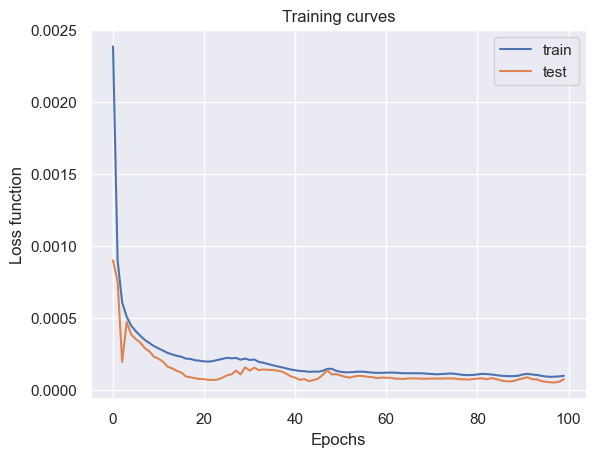

In [315]:
# plot history
plt.title("Training curves")
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss function")
plt.legend()
plt.show()

In [316]:
# make a prediction
yhat = model.predict(test_X)
test_X_ = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X_), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X_), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

730/730 [==============================] - 2s 2ms/step
Test RMSE: 8.781


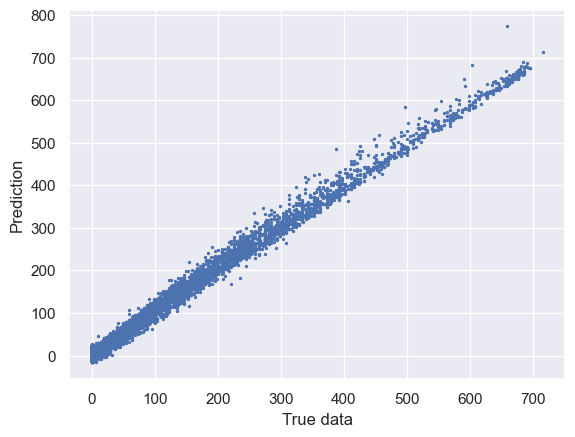

In [317]:
plt.scatter(inv_y, inv_yhat, s=2)
plt.xlabel("True data")
plt.ylabel("Prediction")
plt.show()

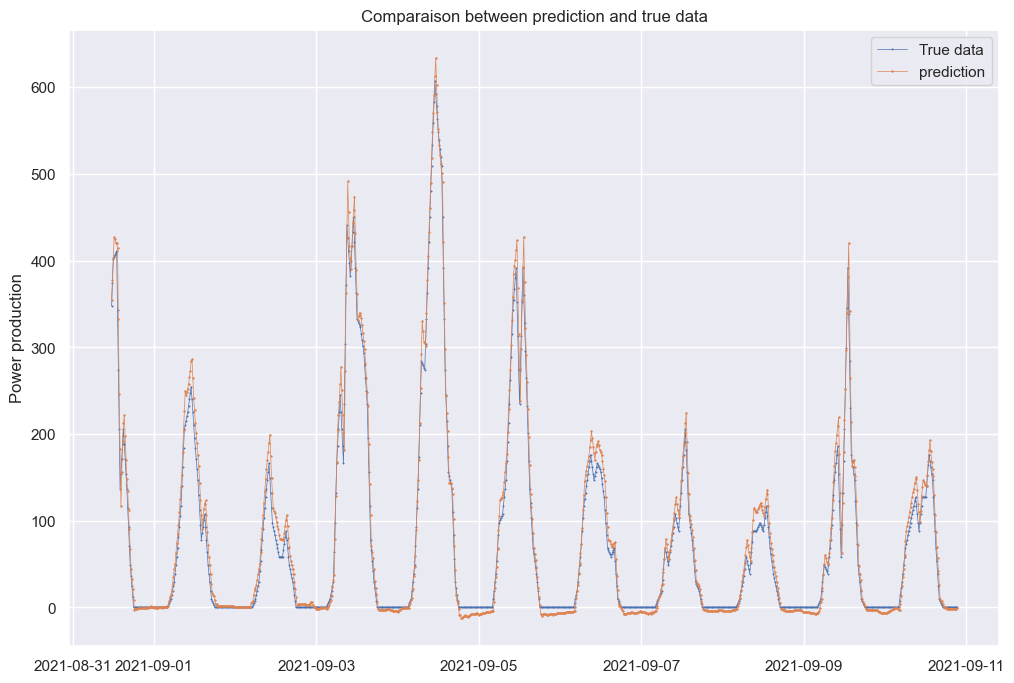

In [332]:
plt.figure(figsize=(12,8))
plt.title("Comparaison between prediction and true data")
plt.plot(reference_dataset.iloc[split:split+1000,1],inv_y[0:1000], '-*',linewidth = 0.5, markersize = 0.8, label='True data')
plt.plot(reference_dataset.iloc[split:split+1000,1],inv_yhat[0:1000],'-+',linewidth = 0.5, markersize = 0.8, label='prediction')
plt.ylabel("Power production")
plt.legend()
plt.show()

In [333]:
reference_dataset

,0,1,2,3,4,5,6,7,8,9,...,107,108,109,110,111,112,113,114,115,116
0,1,2019-01-01 01:15:00,137.199997,5.3,1.240,1074.699951,0.0,1074.699951,1.0,0.0,...,-45.548000,0.0,278.200012,99.199997,13397.299805,3.6,1.3,3.3,-0.0,137.199997
1,2,2019-01-01 01:30:00,137.199997,5.3,1.240,1074.699951,0.0,1074.699951,1.0,0.0,...,-45.548000,0.0,278.200012,99.199997,13397.299805,3.6,1.3,3.3,-0.0,137.199997
2,3,2019-01-01 01:45:00,137.199997,5.3,1.240,1074.699951,0.0,1074.699951,1.0,0.0,...,-44.457001,0.0,278.200012,99.000000,13157.500000,3.7,1.5,3.4,-0.0,137.199997
3,4,2019-01-01 02:00:00,137.199997,5.3,1.240,1074.699951,0.0,1074.699951,1.0,0.0,...,-43.266998,0.0,278.299988,98.699997,12918.000000,3.8,1.7,3.4,-0.0,137.199997
4,5,2019-01-01 02:15:00,137.199997,5.4,1.240,1058.699951,0.0,1058.699951,1.0,0.0,...,-41.987999,0.0,278.299988,98.400002,12678.799805,3.9,1.8,3.4,-0.0,137.199997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116787,116788,2022-05-01 20:00:00,0.000000,5.4,1.253,2604.600098,6.2,1555.699951,0.0,4.1,...,-1.817000,0.0,279.899994,100.000000,38470.898438,3.7,2.9,2.3,-0.0,-0.000000
116788,116789,2022-05-01 20:15:00,0.000000,5.3,1.254,3891.800049,0.0,2092.100098,0.0,0.0,...,-3.075000,0.0,279.799988,100.000000,38281.199219,3.9,2.8,2.6,-0.0,0.000000
116789,116790,2022-05-01 20:30:00,0.000000,5.3,1.254,5179.000000,0.0,2628.600098,0.0,0.0,...,-4.264000,0.0,279.700012,100.000000,38218.800781,4.1,2.9,2.9,-0.0,0.000000
116790,116791,2022-05-01 20:45:00,-0.000000,5.2,1.255,6466.200195,0.0,3165.100098,0.0,0.0,...,-5.379000,0.0,279.500000,100.000000,38205.898438,4.3,2.9,3.1,-0.0,0.000000


In [326]:
split

93433

In [297]:
test =X_Train_obs['date_forecast'].reset_index()
print(test)

         index       date_forecast
0            1 2019-01-01 01:15:00
1            2 2019-01-01 01:30:00
2            3 2019-01-01 01:45:00
3            4 2019-01-01 02:00:00
4            5 2019-01-01 02:15:00
...        ...                 ...
116787  116788 2022-05-01 20:00:00
116788  116789 2022-05-01 20:15:00
116789  116790 2022-05-01 20:30:00
116790  116791 2022-05-01 20:45:00
116791  116792 2022-05-01 21:00:00

[116792 rows x 2 columns]


In [ ]:
# Define your sliding window configuration
window_size = 4*1000  # The past 1000 hours
step_size = 4*500     # Move 500 hours forward

# Create TimeSeriesSplit with sliding window
tscv = TimeSeriesSplit(n_splits=(len(X_train_selected) - window_size) // step_size + 1)

# Initialize variables to store metrics
mse_scores = []

# Loop through the time series cross-validation splits
for train_index, test_index in tscv.split(X_train_selected):
    train_indices = range(train_index[0], train_index[-1] + 1)
    test_indices = range(test_index[0], test_index[-1] + 1)

    X_train = X_train_selected.iloc[train_indices]
    X_test = X_train_selected.iloc[test_indices]
    Y_train = Y_train_selected.iloc[train_indices]
    Y_test = Y_train_selected.iloc[test_indices]
    
    # Reshape data for LSTM input
    X_train = X_train.values.reshape(-1, 1, 1)
    X_test = X_test.values.reshape(-1, 1, 1)
    
    # Create and train the LSTM model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = create_lstm_model(input_shape)
    model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=0)
    
    # Make predictions and calculate Mean Squared Error (MSE)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(Y_test, y_pred)
    mse_scores.append(mse)

# Calculate and print the average MSE across all splits
avg_mse = np.mean(mse_scores)
print(f'Average MSE: {avg_mse}')


# plot predictions
""" 
plt.plot(Y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()
"""



ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).

In [220]:
scaled

array([[0.1372549 , 0.2608696 , 0.33443713, ..., 0.6797753 , 0.5       ,
        0.1372549 ],
       [0.1372549 , 0.2608696 , 0.33443713, ..., 0.6797753 , 0.5       ,
        0.1372549 ],
       [0.1372549 , 0.2608696 , 0.33443713, ..., 0.68539333, 0.5       ,
        0.1372549 ],
       ...,
       [0.        , 0.2608696 , 0.3807943 , ..., 0.6573034 , 0.5       ,
        0.        ],
       [0.        , 0.25543478, 0.38410592, ..., 0.66853935, 0.5       ,
        0.        ],
       [0.        , 0.25      , 0.38741708, ..., 0.68539333, 0.5       ,
        0.        ]], dtype=float32)

AttributeError: 'DataFrame' object has no attribute 'isnan'